In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
SIE = pd.read_csv("data/siemens.csv")
DTE = pd.read_csv("data/deutsche-telekom.csv")
ALV = pd.read_csv("data/allianz.csv")
MRK = pd.read_csv("data/merck-kgaa.csv")
DHL = pd.read_csv("data/deutsche-post.csv")

In [3]:
# Change Dtype of Date column
SIE["Date"] = pd.to_datetime(SIE["Date"])
DTE["Date"] = pd.to_datetime(DTE["Date"])
ALV["Date"] = pd.to_datetime(ALV["Date"])
MRK["Date"] = pd.to_datetime(MRK["Date"])
DHL["Date"] = pd.to_datetime(DHL["Date"])

In [4]:
SIE.set_index('Date', inplace=True)
DTE.set_index('Date', inplace=True)
ALV.set_index('Date', inplace=True)
MRK.set_index('Date', inplace=True)
DHL.set_index('Date', inplace=True)

In [5]:
# Set date variable
start_date = '2010-01-04' # Start date of training set
end_date = '2020-09-30' # End date of training set
test_start_date = '2020-10-01' # End date of test set
test_end_date = '2023-06-30' # End date of test set

In [6]:
# Define a function to split data to train set and test set
def split(df, end_date, test_start_date):
    train = df.loc[:end_date]
    test = df.loc[test_start_date:]
    return train, test

In [7]:
# Define a function to split data to train set and validation set
def split_val(data, rate):
    idx = int(len(data) * rate)
    train = data[:idx]
    val = data[idx:]
    return train, val

In [8]:
# Define a function to process data (Mehtab et al., 2021)
def Dataset(Data, number_features):

    Train_Data = Data.to_numpy()
    Data_Train = []
    Data_Train_X = []
    Data_Train_Y = []
    for i in range(0, len(Train_Data), 5):
        if len(Train_Data[i : i + 5]) == 5:
            Data_Train.append(Train_Data[i : i + 5])

    if len(Data_Train[-1]) < 5:
        Data_Train.pop(-1)

    Data_Train_X = Data_Train[0 : -1]
    Data_Train_X = np.array(Data_Train_X)
    Data_Train_X = Data_Train_X.reshape((-1, 5, number_features))
    
    Train_Label = Data['Close'].to_numpy()
    for i in range(0, len(Train_Label), 5):
        if len(Train_Label[i : i + 5]) == 5:
            Data_Train_Y.append(Train_Label[i : i + 5])
    
    if len(Data_Train_Y[-1]) < 5:
        Data_Train_Y.pop(-1)
    Data_Train_Y = Data_Train_Y[1 : len(Data_Train_Y)]
    Data_Train_Y = np.array(Data_Train_Y)
    Data_Train_Y = Data_Train_Y.reshape((-1, 5, 1))
    
    return Data_Train_X, Data_Train_Y

In [9]:
def scheduler(epoch):
    if epoch <= 150:
        lrate = (10 ** -5) * (epoch / 150) 
    elif epoch <= 400:
        initial_lrate = (10 ** -5)
        k = 0.01
        lrate = initial_lrate * math.exp(-k * (epoch - 150))
    else:
        lrate = (10 ** -6)
    return lrate

# 1. Features = {price, p/e ratio, p/b ratio}

## 1.1. SIE

In [10]:
SIE

,Open,High,Low,Close,Volume,Dividends,Stock Splits,pe-ratio,ps-ratio,pb-ratio,Ticker
Date,,,,,,,,,,,
2010-01-04,39.453722,39.898530,39.362323,39.892437,2734897.0,0.0,0.0,21.092000,0.762592,1.938798,siemens
2010-01-05,39.849782,40.148349,39.593865,39.916805,2584717.0,0.0,0.0,21.092000,0.762592,1.938798,siemens
2010-01-06,39.880244,40.130068,39.752286,40.063042,2166413.0,0.0,0.0,21.092000,0.762592,1.938798,siemens
2010-01-07,40.032576,40.702835,39.709636,40.538315,3336865.0,0.0,0.0,21.092000,0.762592,1.938798,siemens
2010-01-08,40.733299,40.964843,40.325055,40.794235,2634386.0,0.0,0.0,21.092000,0.762592,1.938798,siemens
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,157.399994,157.699997,155.320007,155.479996,1312767.0,0.0,0.0,19.691292,1.515738,1.998793,siemens
2023-06-27,156.399994,158.039993,155.979996,157.559998,1065494.0,0.0,0.0,19.691292,1.515738,1.998793,siemens
2023-06-28,158.940002,159.639999,150.399994,152.720001,2094689.0,0.0,0.0,19.691292,1.515738,1.998793,siemens


In [11]:
SIE.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3449 entries, 2010-01-04 to 2023-06-30
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3449 non-null   float64
 1   High          3449 non-null   float64
 2   Low           3449 non-null   float64
 3   Close         3449 non-null   float64
 4   Volume        3449 non-null   float64
 5   Dividends     3449 non-null   float64
 6   Stock Splits  3449 non-null   float64
 7   pe-ratio      3449 non-null   float64
 8   ps-ratio      3449 non-null   float64
 9   pb-ratio      3449 non-null   float64
 10  Ticker        3449 non-null   object 
dtypes: float64(10), object(1)
memory usage: 323.3+ KB


In [12]:
SIE_df1 = SIE[["Close", "pe-ratio", "pb-ratio"]]
SIE_df1

,Close,pe-ratio,pb-ratio
Date,,,
2010-01-04,39.892437,21.092000,1.938798
2010-01-05,39.916805,21.092000,1.938798
2010-01-06,40.063042,21.092000,1.938798
2010-01-07,40.538315,21.092000,1.938798
2010-01-08,40.794235,21.092000,1.938798
...,...,...,...
2023-06-26,155.479996,19.691292,1.998793
2023-06-27,157.559998,19.691292,1.998793
2023-06-28,152.720001,19.691292,1.998793


### Data Proprocessing

In [13]:
# Split data to train set and test set
train, test = split(SIE_df1, end_date, test_start_date)

In [14]:
# Reconcile length of data set and subsets
SIE_df1.shape[0] == train.shape[0] + test.shape[0]

True

In [15]:
# Process data
X_train, y_train = Dataset(train, 3)
X_test, y_test = Dataset(test, 3)

In [16]:
# Split train set to train set and validation set
X_train, X_val = split_val(X_train, 0.8)
y_train, y_val = split_val(y_train, 0.8)

### Model

In [17]:
# Define model (Mehtab et al., 2021)
def Model():
    model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 3), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(300, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
    return model

In [18]:
model = Model()

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 200)            163200    
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 300)               60300     
                                                                 
 dense_1 (Dense)             (None, 200)               60200     
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 50)                5050      
                                                                 
 dense_4 (Dense)             (None, 5)                 2

### Custom Learning Rate

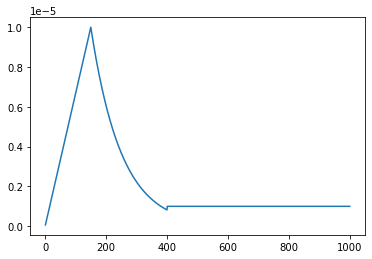

In [20]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [21]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Learning

In [22]:
# Compile model (Mehtab et al., 2021)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [23]:
# Fit model (Mehtab et al., 2021)
hist = model.fit(X_train, y_train, epochs = 200, validation_data = (X_val, y_val), callbacks=[callback])

Epoch 1/200
14/14 [==============================] - 4s 67ms/step - loss: 5032.1499 - root_mean_squared_error: 70.9377 - val_loss: 8379.0303 - val_root_mean_squared_error: 91.5370 - lr: 0.0000e+00
Epoch 2/200
14/14 [==============================] - 0s 23ms/step - loss: 5032.0825 - root_mean_squared_error: 70.9372 - val_loss: 8378.7959 - val_root_mean_squared_error: 91.5358 - lr: 6.6667e-08
Epoch 3/200
14/14 [==============================] - 0s 23ms/step - loss: 5031.8696 - root_mean_squared_error: 70.9357 - val_loss: 8378.3115 - val_root_mean_squared_error: 91.5331 - lr: 1.3333e-07
Epoch 4/200
14/14 [==============================] - 0s 25ms/step - loss: 5031.5044 - root_mean_squared_error: 70.9331 - val_loss: 8377.5674 - val_root_mean_squared_error: 91.5291 - lr: 2.0000e-07
Epoch 5/200
14/14 [==============================] - 0s 24ms/step - loss: 5030.9932 - root_mean_squared_error: 70.9295 - val_loss: 8376.5146 - val_root_mean_squared_error: 91.5233 - lr: 2.6667e-07
Epoch 6/200
14/

14/14 [==============================] - 0s 22ms/step - loss: 401.2061 - root_mean_squared_error: 20.0301 - val_loss: 545.6509 - val_root_mean_squared_error: 23.3592 - lr: 5.4667e-06
Epoch 84/200
14/14 [==============================] - 0s 28ms/step - loss: 278.8647 - root_mean_squared_error: 16.6992 - val_loss: 384.6588 - val_root_mean_squared_error: 19.6127 - lr: 5.5333e-06
Epoch 85/200
14/14 [==============================] - 0s 28ms/step - loss: 195.0784 - root_mean_squared_error: 13.9670 - val_loss: 276.0643 - val_root_mean_squared_error: 16.6152 - lr: 5.6000e-06
Epoch 86/200
14/14 [==============================] - 0s 27ms/step - loss: 140.7269 - root_mean_squared_error: 11.8628 - val_loss: 199.8844 - val_root_mean_squared_error: 14.1380 - lr: 5.6667e-06
Epoch 87/200
14/14 [==============================] - 0s 28ms/step - loss: 101.5407 - root_mean_squared_error: 10.0767 - val_loss: 149.5298 - val_root_mean_squared_error: 12.2282 - lr: 5.7333e-06
Epoch 88/200
14/14 [=============

Epoch 126/200
14/14 [==============================] - 0s 29ms/step - loss: 5.7525 - root_mean_squared_error: 2.3984 - val_loss: 17.9750 - val_root_mean_squared_error: 4.2397 - lr: 8.3333e-06
Epoch 127/200
14/14 [==============================] - 0s 29ms/step - loss: 5.7351 - root_mean_squared_error: 2.3948 - val_loss: 18.0530 - val_root_mean_squared_error: 4.2489 - lr: 8.4000e-06
Epoch 128/200
14/14 [==============================] - 0s 29ms/step - loss: 5.7143 - root_mean_squared_error: 2.3905 - val_loss: 17.9683 - val_root_mean_squared_error: 4.2389 - lr: 8.4667e-06
Epoch 129/200
14/14 [==============================] - 0s 29ms/step - loss: 5.7018 - root_mean_squared_error: 2.3879 - val_loss: 18.0530 - val_root_mean_squared_error: 4.2489 - lr: 8.5333e-06
Epoch 130/200
14/14 [==============================] - 0s 28ms/step - loss: 5.6712 - root_mean_squared_error: 2.3814 - val_loss: 17.8933 - val_root_mean_squared_error: 4.2301 - lr: 8.6000e-06
Epoch 131/200
14/14 [===================

Epoch 169/200
14/14 [==============================] - 0s 28ms/step - loss: 5.0142 - root_mean_squared_error: 2.2392 - val_loss: 16.5270 - val_root_mean_squared_error: 4.0653 - lr: 8.3527e-06
Epoch 170/200
14/14 [==============================] - 0s 27ms/step - loss: 5.0261 - root_mean_squared_error: 2.2419 - val_loss: 16.4948 - val_root_mean_squared_error: 4.0614 - lr: 8.2696e-06
Epoch 171/200
14/14 [==============================] - 0s 28ms/step - loss: 4.9582 - root_mean_squared_error: 2.2267 - val_loss: 16.2786 - val_root_mean_squared_error: 4.0347 - lr: 8.1873e-06
Epoch 172/200
14/14 [==============================] - 0s 27ms/step - loss: 4.9555 - root_mean_squared_error: 2.2261 - val_loss: 16.4187 - val_root_mean_squared_error: 4.0520 - lr: 8.1058e-06
Epoch 173/200
14/14 [==============================] - 0s 29ms/step - loss: 4.9342 - root_mean_squared_error: 2.2213 - val_loss: 16.2716 - val_root_mean_squared_error: 4.0338 - lr: 8.0252e-06
Epoch 174/200
14/14 [===================

In [24]:
history_dict = hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

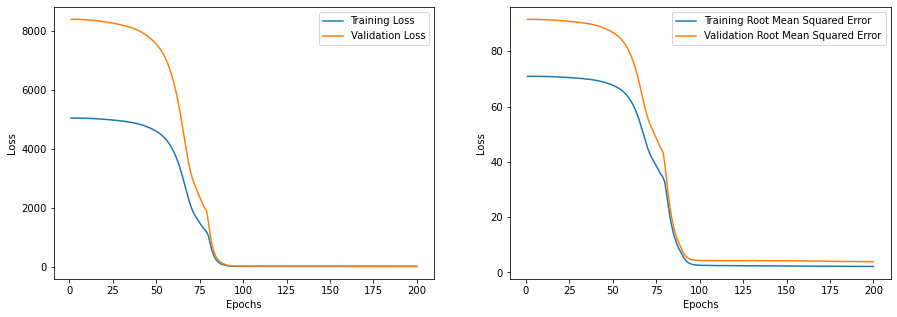

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Prediction

In [26]:
prediction = model.predict(X_test)

5/5 [==============================] - 0s 9ms/step


In [27]:
len(prediction.reshape(-1))

695

In [28]:
temp1 = test.tail(695)

In [29]:
temp1['Forecast'] = prediction.reshape(-1)

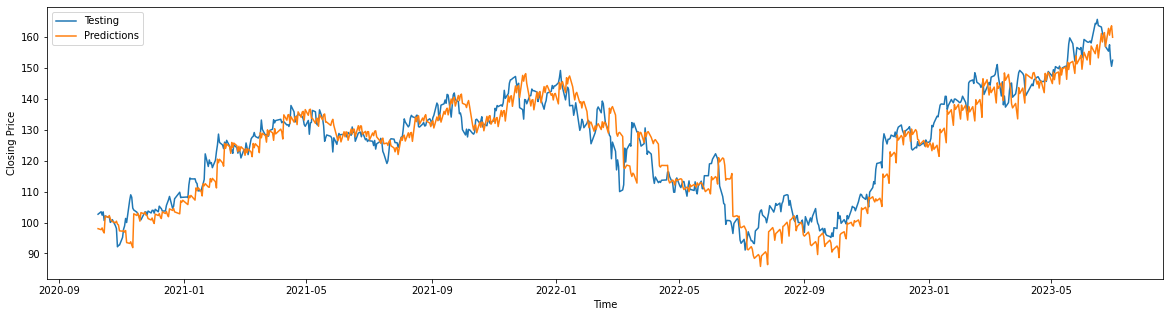

In [30]:
plt.figure(figsize=(20, 5))
plt.plot(temp1['Close'], label = 'Testing')
plt.plot(temp1['Forecast'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [31]:
rmse = math.sqrt(mean_squared_error(y_test.reshape(-1, 5), prediction))
mape = np.mean(np.abs(prediction - y_test.reshape(-1, 5))/np.abs(y_test.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 5.51050041055214
MAPE: 0.034541180333851104


In [32]:
temp1

,Close,pe-ratio,pb-ratio,Forecast
Date,,,,
2020-10-09,102.678017,21.575999,2.165320,98.008797
2020-10-12,103.487961,21.575999,2.165320,97.680115
2020-10-13,102.383484,21.575999,2.165320,98.243057
2020-10-14,103.451141,21.575999,2.165320,97.171494
2020-10-15,100.634758,21.575999,2.165320,96.614372
...,...,...,...,...
2023-06-26,155.479996,19.691292,1.998793,162.862976
2023-06-27,157.559998,19.691292,1.998793,160.656967
2023-06-28,152.720001,19.691292,1.998793,162.757492


In [33]:
# Create a dataframe that has same index as SIE dataframe
result1 = pd.DataFrame(index=SIE.index)
# Extract actual data from SIE
tem1 = SIE['Close'].tolist()[:len(SIE)-695]
# Extract forecasted date from above result
tem2 = temp1['Forecast'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['SIE'] = tem3
# Mark forecasted or not for each line
result1['Forecasted'] = 'N'
result1.loc[result1.index[-695:], 'Forecasted'] = 'Y'

In [34]:
result1

,SIE,Forecasted
Date,,
2010-01-04,39.892437,N
2010-01-05,39.916805,N
2010-01-06,40.063042,N
2010-01-07,40.538315,N
2010-01-08,40.794235,N
...,...,...
2023-06-26,162.862976,Y
2023-06-27,160.656967,Y
2023-06-28,162.757492,Y


## 1.2. DTE

In [35]:
DTE

,Open,High,Low,Close,Volume,Dividends,Stock Splits,pe-ratio,ps-ratio,pb-ratio,Ticker
Date,,,,,,,,,,,
2010-01-04,4.826971,4.953136,4.817626,4.953136,14257860.0,0.0,0.0,128.625000,0.707311,1.070129,deutsche-telekom
2010-01-05,4.948465,4.953138,4.871364,4.911083,14077418.0,0.0,0.0,128.625000,0.707311,1.070129,deutsche-telekom
2010-01-06,4.831645,4.833982,4.770899,4.789590,28100490.0,0.0,0.0,128.625000,0.707311,1.070129,deutsche-telekom
2010-01-07,4.766226,4.770899,4.663425,4.698472,21799244.0,0.0,0.0,128.625000,0.707311,1.070129,deutsche-telekom
2010-01-08,4.707817,4.728844,4.668565,4.724171,20945576.0,0.0,0.0,128.625000,0.707311,1.070129,deutsche-telekom
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,19.528000,19.733999,19.493999,19.695999,6407184.0,0.0,0.0,5.658228,1.014428,1.057418,deutsche-telekom
2023-06-27,19.830000,19.968000,19.712000,19.906000,0.0,0.0,0.0,5.658228,1.014428,1.057418,deutsche-telekom
2023-06-28,20.000000,20.155001,19.927999,20.030001,8299496.0,0.0,0.0,5.658228,1.014428,1.057418,deutsche-telekom


In [36]:
DTE.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3449 entries, 2010-01-04 to 2023-06-30
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3449 non-null   float64
 1   High          3449 non-null   float64
 2   Low           3449 non-null   float64
 3   Close         3449 non-null   float64
 4   Volume        3449 non-null   float64
 5   Dividends     3449 non-null   float64
 6   Stock Splits  3449 non-null   float64
 7   pe-ratio      3449 non-null   float64
 8   ps-ratio      3449 non-null   float64
 9   pb-ratio      3449 non-null   float64
 10  Ticker        3449 non-null   object 
dtypes: float64(10), object(1)
memory usage: 323.3+ KB


In [37]:
DTE_df1 = DTE[["Close" , "pe-ratio" , "pb-ratio"]]
DTE_df1

,Close,pe-ratio,pb-ratio
Date,,,
2010-01-04,4.953136,128.625000,1.070129
2010-01-05,4.911083,128.625000,1.070129
2010-01-06,4.789590,128.625000,1.070129
2010-01-07,4.698472,128.625000,1.070129
2010-01-08,4.724171,128.625000,1.070129
...,...,...,...
2023-06-26,19.695999,5.658228,1.057418
2023-06-27,19.906000,5.658228,1.057418
2023-06-28,20.030001,5.658228,1.057418


### Data Proprocessing

In [38]:
# Split data to train set and test set
train, test = split(DTE_df1, end_date, test_start_date)

In [39]:
# Reconcile length of data set and subsets
DTE_df1.shape[0] == train.shape[0] + test.shape[0]

True

In [40]:
# Process data
X_train, y_train = Dataset(train, 3)
X_test, y_test = Dataset(test, 3)

In [41]:
# Split train set to train set and validation set
X_train, X_val = split_val(X_train, 0.8)
y_train, y_val = split_val(y_train, 0.8)

### Model

In [42]:
# Define model (Mehtab et al., 2021)
def Model():
    model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 3), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
    return model

In [43]:
model = Model()

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 200)            163200    
                                                                 
 lstm_3 (LSTM)               (None, 200)               320800    
                                                                 
 dense_5 (Dense)             (None, 200)               40200     
                                                                 
 dense_6 (Dense)             (None, 100)               20100     
                                                                 
 dense_7 (Dense)             (None, 50)                5050      
                                                                 
 dense_8 (Dense)             (None, 5)                 255       
                                                                 
Total params: 549,605
Trainable params: 549,605
Non-tr

### Custom Learning Rate

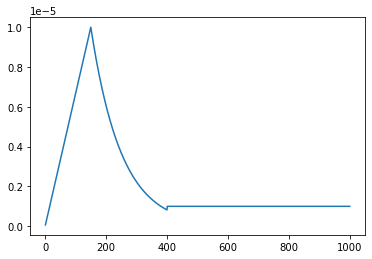

In [45]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [46]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Learning

In [47]:
# Compile model (Mehtab et al., 2021)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [48]:
# Fit model (Mehtab et al., 2021)
hist = model.fit(X_train, y_train, epochs = 200, validation_data = (X_val, y_val), callbacks=[callback])

Epoch 1/200
14/14 [==============================] - 4s 57ms/step - loss: 67.9594 - root_mean_squared_error: 8.2437 - val_loss: 146.4999 - val_root_mean_squared_error: 12.1037 - lr: 0.0000e+00
Epoch 2/200
14/14 [==============================] - 0s 20ms/step - loss: 67.9530 - root_mean_squared_error: 8.2434 - val_loss: 146.4933 - val_root_mean_squared_error: 12.1034 - lr: 6.6667e-08
Epoch 3/200
14/14 [==============================] - 0s 23ms/step - loss: 67.9324 - root_mean_squared_error: 8.2421 - val_loss: 146.4803 - val_root_mean_squared_error: 12.1029 - lr: 1.3333e-07
Epoch 4/200
14/14 [==============================] - 0s 24ms/step - loss: 67.8984 - root_mean_squared_error: 8.2400 - val_loss: 146.4604 - val_root_mean_squared_error: 12.1021 - lr: 2.0000e-07
Epoch 5/200
14/14 [==============================] - 0s 25ms/step - loss: 67.8514 - root_mean_squared_error: 8.2372 - val_loss: 146.4342 - val_root_mean_squared_error: 12.1010 - lr: 2.6667e-07
Epoch 6/200
14/14 [================

14/14 [==============================] - 0s 26ms/step - loss: 9.8985 - root_mean_squared_error: 3.1462 - val_loss: 13.2781 - val_root_mean_squared_error: 3.6439 - lr: 5.6000e-06
Epoch 86/200
14/14 [==============================] - 0s 25ms/step - loss: 9.1732 - root_mean_squared_error: 3.0287 - val_loss: 11.3824 - val_root_mean_squared_error: 3.3738 - lr: 5.6667e-06
Epoch 87/200
14/14 [==============================] - 0s 28ms/step - loss: 8.5442 - root_mean_squared_error: 2.9230 - val_loss: 9.8071 - val_root_mean_squared_error: 3.1316 - lr: 5.7333e-06
Epoch 88/200
14/14 [==============================] - 0s 27ms/step - loss: 7.9872 - root_mean_squared_error: 2.8262 - val_loss: 8.2750 - val_root_mean_squared_error: 2.8766 - lr: 5.8000e-06
Epoch 89/200
14/14 [==============================] - 0s 26ms/step - loss: 7.4549 - root_mean_squared_error: 2.7304 - val_loss: 7.1099 - val_root_mean_squared_error: 2.6664 - lr: 5.8667e-06
Epoch 90/200
14/14 [==============================] - 0s 25ms

14/14 [==============================] - 0s 28ms/step - loss: 0.5096 - root_mean_squared_error: 0.7139 - val_loss: 1.4215 - val_root_mean_squared_error: 1.1923 - lr: 8.4667e-06
Epoch 129/200
14/14 [==============================] - 0s 26ms/step - loss: 0.4830 - root_mean_squared_error: 0.6950 - val_loss: 1.4787 - val_root_mean_squared_error: 1.2160 - lr: 8.5333e-06
Epoch 130/200
14/14 [==============================] - 0s 26ms/step - loss: 0.4531 - root_mean_squared_error: 0.6731 - val_loss: 1.3436 - val_root_mean_squared_error: 1.1591 - lr: 8.6000e-06
Epoch 131/200
14/14 [==============================] - 0s 26ms/step - loss: 0.4302 - root_mean_squared_error: 0.6559 - val_loss: 1.4082 - val_root_mean_squared_error: 1.1867 - lr: 8.6667e-06
Epoch 132/200
14/14 [==============================] - 0s 25ms/step - loss: 0.4085 - root_mean_squared_error: 0.6391 - val_loss: 1.3934 - val_root_mean_squared_error: 1.1804 - lr: 8.7333e-06
Epoch 133/200
14/14 [==============================] - 0s 2

Epoch 171/200
14/14 [==============================] - 0s 27ms/step - loss: 0.1698 - root_mean_squared_error: 0.4121 - val_loss: 1.0346 - val_root_mean_squared_error: 1.0171 - lr: 8.1873e-06
Epoch 172/200
14/14 [==============================] - 0s 27ms/step - loss: 0.1688 - root_mean_squared_error: 0.4109 - val_loss: 0.9773 - val_root_mean_squared_error: 0.9886 - lr: 8.1058e-06
Epoch 173/200
14/14 [==============================] - 0s 26ms/step - loss: 0.1682 - root_mean_squared_error: 0.4102 - val_loss: 0.9885 - val_root_mean_squared_error: 0.9942 - lr: 8.0252e-06
Epoch 174/200
14/14 [==============================] - 0s 19ms/step - loss: 0.1665 - root_mean_squared_error: 0.4081 - val_loss: 0.9875 - val_root_mean_squared_error: 0.9937 - lr: 7.9453e-06
Epoch 175/200
14/14 [==============================] - 0s 27ms/step - loss: 0.1657 - root_mean_squared_error: 0.4070 - val_loss: 0.9444 - val_root_mean_squared_error: 0.9718 - lr: 7.8663e-06
Epoch 176/200
14/14 [========================

In [49]:
history_dict = hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

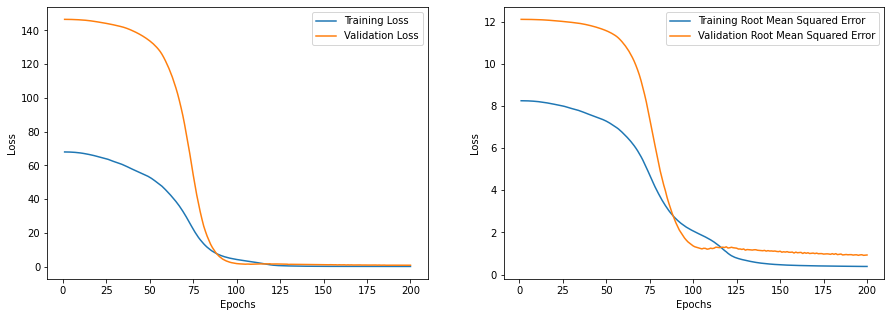

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Prediction

In [51]:
prediction = model.predict(X_test)

5/5 [==============================] - 0s 9ms/step


In [52]:
len(prediction.reshape(-1))

695

In [53]:
temp1 = test.tail(695)

In [54]:
temp1['Forecast'] = prediction.reshape(-1)

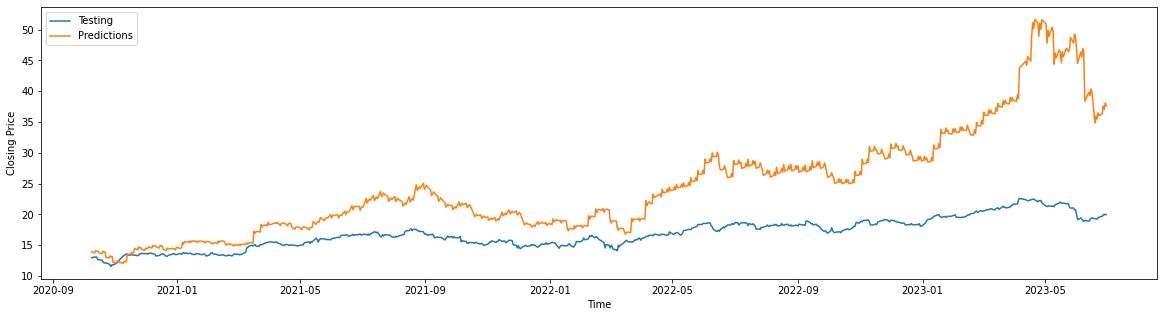

In [55]:
plt.figure(figsize=(20, 5))
plt.plot(temp1['Close'], label = 'Testing')
plt.plot(temp1['Forecast'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [56]:
rmse = math.sqrt(mean_squared_error(y_test.reshape(-1, 5), prediction))
mape = np.mean(np.abs(prediction - y_test.reshape(-1, 5))/np.abs(y_test.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 9.972314166356046
MAPE: 0.4188685124214884


In [57]:
temp1

,Close,pe-ratio,pb-ratio,Forecast
Date,,,,
2020-10-09,12.981357,21.651515,0.940896,13.926499
2020-10-12,13.067026,21.651515,0.940896,13.756289
2020-10-13,13.107607,21.651515,0.940896,14.156539
2020-10-14,13.053500,21.651515,0.940896,14.019782
2020-10-15,12.643183,21.651515,0.940896,14.083917
...,...,...,...,...
2023-06-26,19.695999,5.658228,1.057418,36.315617
2023-06-27,19.906000,5.658228,1.057418,37.594303
2023-06-28,20.030001,5.658228,1.057418,37.063148


In [58]:
# Extract actual data from SIE
tem1 = DTE['Close'].tolist()[:len(DTE)-695]
# Extract forecasted date from above result
tem2 = temp1['Forecast'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['DTE'] = tem3

In [59]:
result1

,SIE,Forecasted,DTE
Date,,,
2010-01-04,39.892437,N,4.953136
2010-01-05,39.916805,N,4.911083
2010-01-06,40.063042,N,4.789590
2010-01-07,40.538315,N,4.698472
2010-01-08,40.794235,N,4.724171
...,...,...,...
2023-06-26,162.862976,Y,36.315617
2023-06-27,160.656967,Y,37.594303
2023-06-28,162.757492,Y,37.063148


## 1.3. ALV

In [60]:
ALV

,Open,High,Low,Close,Volume,Dividends,Stock Splits,pe-ratio,ps-ratio,pb-ratio,Ticker
Date,,,,,,,,,,,
2010-01-04,45.138680,45.699056,45.035857,45.519119,1676777.0,0.0,0.0,9.154412,0.706716,1.292624,allianz
2010-01-05,45.498549,46.110338,45.395729,45.657921,1742206.0,0.0,0.0,9.154412,0.706716,1.292624,allianz
2010-01-06,45.832728,46.161757,45.627084,46.012665,1362139.0,0.0,0.0,9.154412,0.706716,1.292624,allianz
2010-01-07,45.714478,45.981817,45.421437,45.483131,1926360.0,0.0,0.0,9.154412,0.706716,1.292624,allianz
2010-01-08,45.848145,45.848145,44.562875,45.236355,2425290.0,0.0,0.0,9.154412,0.706716,1.292624,allianz
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,209.800003,209.800003,207.699997,209.199997,532054.0,0.0,0.0,10.264393,0.759921,1.461468,allianz
2023-06-27,210.149994,211.449997,209.649994,211.300003,640049.0,0.0,0.0,10.264393,0.759921,1.461468,allianz
2023-06-28,212.000000,212.800003,210.750000,211.649994,575057.0,0.0,0.0,10.264393,0.759921,1.461468,allianz


In [61]:
ALV.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3449 entries, 2010-01-04 to 2023-06-30
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3449 non-null   float64
 1   High          3449 non-null   float64
 2   Low           3449 non-null   float64
 3   Close         3449 non-null   float64
 4   Volume        3449 non-null   float64
 5   Dividends     3449 non-null   float64
 6   Stock Splits  3449 non-null   float64
 7   pe-ratio      3449 non-null   float64
 8   ps-ratio      3449 non-null   float64
 9   pb-ratio      3449 non-null   float64
 10  Ticker        3449 non-null   object 
dtypes: float64(10), object(1)
memory usage: 323.3+ KB


In [62]:
ALV_df1 = ALV[["Close", "pe-ratio", "pb-ratio"]]
ALV_df1

,Close,pe-ratio,pb-ratio
Date,,,
2010-01-04,45.519119,9.154412,1.292624
2010-01-05,45.657921,9.154412,1.292624
2010-01-06,46.012665,9.154412,1.292624
2010-01-07,45.483131,9.154412,1.292624
2010-01-08,45.236355,9.154412,1.292624
...,...,...,...
2023-06-26,209.199997,10.264393,1.461468
2023-06-27,211.300003,10.264393,1.461468
2023-06-28,211.649994,10.264393,1.461468


### Data Proprocessing

In [63]:
# Split data to train set and test set
train, test = split(ALV_df1, end_date, test_start_date)

In [64]:
# Reconcile length of data set and subsets
ALV_df1.shape[0] == train.shape[0] + test.shape[0]

True

In [65]:
# Process data
X_train, y_train = Dataset(train, 3)
X_test, y_test = Dataset(test, 3)

In [66]:
# Split train set to train set and validation set
X_train, X_val = split_val(X_train, 0.8)
y_train, y_val = split_val(y_train, 0.8)

### Model

In [67]:
# Define model (Mehtab et al., 2021)
def Model():
    model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 3), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
    return model

In [68]:
model = Model()

In [69]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 5, 200)            163200    
                                                                 
 lstm_5 (LSTM)               (None, 200)               320800    
                                                                 
 dense_9 (Dense)             (None, 200)               40200     
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 50)                5050      
                                                                 
 dense_12 (Dense)            (None, 5)                 255       
                                                                 
Total params: 549,605
Trainable params: 549,605
Non-tr

### Custom Learning Rate

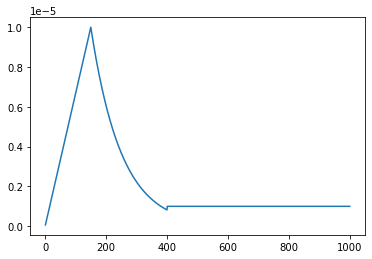

In [70]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [71]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Learning

In [72]:
# Compile model (Mehtab et al., 2021)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [73]:
# Fit model (Mehtab et al., 2021)
hist = model.fit(X_train, y_train, epochs = 200, validation_data = (X_val, y_val), callbacks=[callback])

Epoch 1/200
14/14 [==============================] - 4s 58ms/step - loss: 7663.3198 - root_mean_squared_error: 87.5404 - val_loss: 23828.0000 - val_root_mean_squared_error: 154.3632 - lr: 0.0000e+00
Epoch 2/200
14/14 [==============================] - 0s 20ms/step - loss: 7663.1143 - root_mean_squared_error: 87.5392 - val_loss: 23826.2168 - val_root_mean_squared_error: 154.3574 - lr: 6.6667e-08
Epoch 3/200
14/14 [==============================] - 0s 26ms/step - loss: 7662.4326 - root_mean_squared_error: 87.5353 - val_loss: 23822.7656 - val_root_mean_squared_error: 154.3463 - lr: 1.3333e-07
Epoch 4/200
14/14 [==============================] - 0s 24ms/step - loss: 7661.3120 - root_mean_squared_error: 87.5289 - val_loss: 23817.4395 - val_root_mean_squared_error: 154.3290 - lr: 2.0000e-07
Epoch 5/200
14/14 [==============================] - 0s 27ms/step - loss: 7659.7002 - root_mean_squared_error: 87.5197 - val_loss: 23810.3926 - val_root_mean_squared_error: 154.3062 - lr: 2.6667e-07
Epoch

14/14 [==============================] - 0s 24ms/step - loss: 7152.6987 - root_mean_squared_error: 84.5736 - val_loss: 21959.3984 - val_root_mean_squared_error: 148.1870 - lr: 2.7333e-06
Epoch 43/200
14/14 [==============================] - 0s 25ms/step - loss: 7118.4673 - root_mean_squared_error: 84.3710 - val_loss: 21842.5957 - val_root_mean_squared_error: 147.7924 - lr: 2.8000e-06
Epoch 44/200
14/14 [==============================] - 0s 25ms/step - loss: 7081.5615 - root_mean_squared_error: 84.1520 - val_loss: 21718.3633 - val_root_mean_squared_error: 147.3715 - lr: 2.8667e-06
Epoch 45/200
14/14 [==============================] - 0s 25ms/step - loss: 7042.8887 - root_mean_squared_error: 83.9219 - val_loss: 21582.5781 - val_root_mean_squared_error: 146.9101 - lr: 2.9333e-06
Epoch 46/200
14/14 [==============================] - 0s 29ms/step - loss: 7000.4907 - root_mean_squared_error: 83.6689 - val_loss: 21440.7520 - val_root_mean_squared_error: 146.4266 - lr: 3.0000e-06
Epoch 47/200


Epoch 126/200
14/14 [==============================] - 0s 21ms/step - loss: 8.3123 - root_mean_squared_error: 2.8831 - val_loss: 60.5025 - val_root_mean_squared_error: 7.7783 - lr: 8.3333e-06
Epoch 127/200
14/14 [==============================] - 0s 25ms/step - loss: 8.2940 - root_mean_squared_error: 2.8799 - val_loss: 60.3725 - val_root_mean_squared_error: 7.7700 - lr: 8.4000e-06
Epoch 128/200
14/14 [==============================] - 0s 26ms/step - loss: 8.2789 - root_mean_squared_error: 2.8773 - val_loss: 60.0199 - val_root_mean_squared_error: 7.7473 - lr: 8.4667e-06
Epoch 129/200
14/14 [==============================] - 0s 28ms/step - loss: 8.2571 - root_mean_squared_error: 2.8735 - val_loss: 60.0000 - val_root_mean_squared_error: 7.7460 - lr: 8.5333e-06
Epoch 130/200
14/14 [==============================] - 0s 23ms/step - loss: 8.2284 - root_mean_squared_error: 2.8685 - val_loss: 59.4824 - val_root_mean_squared_error: 7.7125 - lr: 8.6000e-06
Epoch 131/200
14/14 [===================

Epoch 169/200
14/14 [==============================] - 0s 27ms/step - loss: 7.1814 - root_mean_squared_error: 2.6798 - val_loss: 49.6169 - val_root_mean_squared_error: 7.0439 - lr: 8.3527e-06
Epoch 170/200
14/14 [==============================] - 0s 26ms/step - loss: 7.1662 - root_mean_squared_error: 2.6770 - val_loss: 49.4587 - val_root_mean_squared_error: 7.0327 - lr: 8.2696e-06
Epoch 171/200
14/14 [==============================] - 0s 25ms/step - loss: 7.1801 - root_mean_squared_error: 2.6796 - val_loss: 49.2323 - val_root_mean_squared_error: 7.0166 - lr: 8.1873e-06
Epoch 172/200
14/14 [==============================] - 0s 25ms/step - loss: 7.1102 - root_mean_squared_error: 2.6665 - val_loss: 49.1445 - val_root_mean_squared_error: 7.0103 - lr: 8.1058e-06
Epoch 173/200
14/14 [==============================] - 0s 28ms/step - loss: 7.1241 - root_mean_squared_error: 2.6691 - val_loss: 48.9517 - val_root_mean_squared_error: 6.9965 - lr: 8.0252e-06
Epoch 174/200
14/14 [===================

In [74]:
history_dict = hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

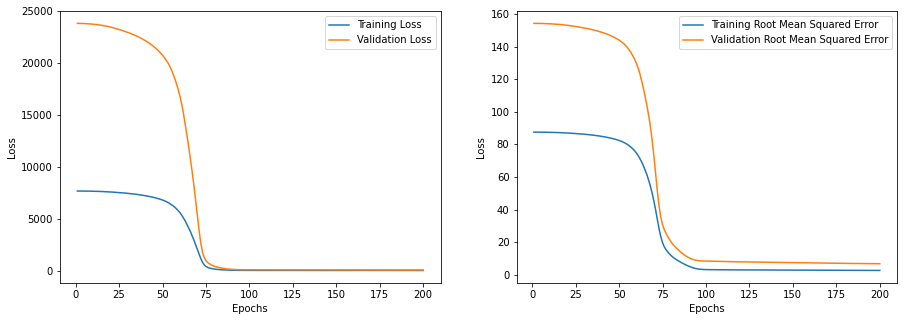

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Prediction

In [76]:
prediction = model.predict(X_test)

5/5 [==============================] - 0s 8ms/step


In [77]:
len(prediction.reshape(-1))

695

In [78]:
temp1 = test.tail(695)

In [79]:
temp1['Forecast'] = prediction.reshape(-1)

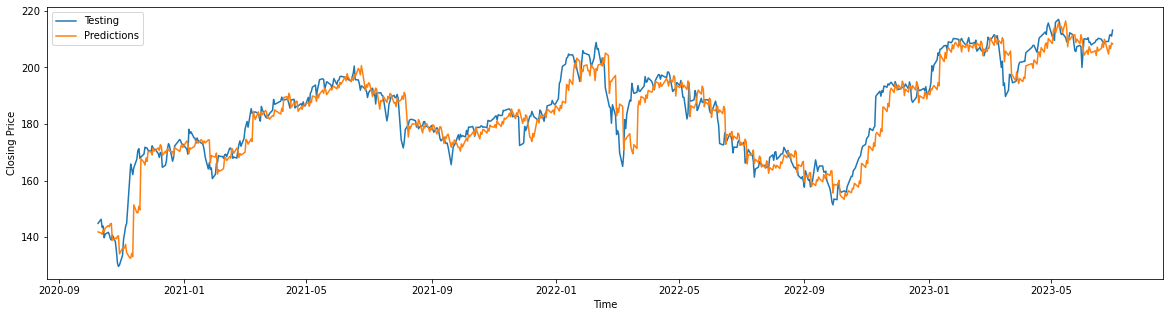

In [80]:
plt.figure(figsize=(20, 5))
plt.plot(temp1['Close'], label = 'Testing')
plt.plot(temp1['Forecast'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [81]:
rmse = math.sqrt(mean_squared_error(y_test.reshape(-1, 5), prediction))
mape = np.mean(np.abs(prediction - y_test.reshape(-1, 5))/np.abs(y_test.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 5.398348552201936
MAPE: 0.020265567351951466


In [82]:
temp1

,Close,pe-ratio,pb-ratio,Forecast
Date,,,,
2020-10-09,144.838226,9.953418,0.874770,141.831024
2020-10-12,146.302643,9.953418,0.874770,141.415482
2020-10-13,143.442734,9.953418,0.874770,140.961792
2020-10-14,143.873459,9.953418,0.874770,142.385605
2020-10-15,139.755890,9.953418,0.874770,141.839264
...,...,...,...,...
2023-06-26,209.199997,10.264393,1.461468,204.726959
2023-06-27,211.300003,10.264393,1.461468,207.693985
2023-06-28,211.649994,10.264393,1.461468,206.646469


In [83]:
# Extract actual data from SIE
tem1 = ALV['Close'].tolist()[:len(ALV)-695]
# Extract forecasted date from above result
tem2 = temp1['Forecast'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['ALV'] = tem3

In [84]:
result1

,SIE,Forecasted,DTE,ALV
Date,,,,
2010-01-04,39.892437,N,4.953136,45.519119
2010-01-05,39.916805,N,4.911083,45.657921
2010-01-06,40.063042,N,4.789590,46.012665
2010-01-07,40.538315,N,4.698472,45.483131
2010-01-08,40.794235,N,4.724171,45.236355
...,...,...,...,...
2023-06-26,162.862976,Y,36.315617,204.726959
2023-06-27,160.656967,Y,37.594303,207.693985
2023-06-28,162.757492,Y,37.063148,206.646469


## 1.4. MRK

In [85]:
MRK

,Open,High,Low,Close,Volume,Dividends,Stock Splits,pe-ratio,ps-ratio,pb-ratio,Ticker
Date,,,,,,,,,,,
2010-01-04,26.572763,26.780618,26.438271,26.576839,752504.0,0.0,0.0,38.785717,NaN,1.488928,merck-kgaa
2010-01-05,26.527932,26.560537,26.238566,26.381214,488178.0,0.0,0.0,38.785717,NaN,1.488928,merck-kgaa
2010-01-06,26.409742,26.576839,26.140752,26.364910,511138.0,0.0,0.0,38.785717,NaN,1.488928,merck-kgaa
2010-01-07,26.324151,26.972169,26.324151,26.919188,1088580.0,0.0,0.0,38.785717,NaN,1.488928,merck-kgaa
2010-01-08,26.919186,27.053678,26.328226,26.646120,730274.0,0.0,0.0,38.785717,NaN,1.488928,merck-kgaa
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,153.000000,154.399994,152.000000,152.600006,255508.0,0.0,0.0,23.026846,3.467976,3.013593,merck-kgaa
2023-06-27,152.250000,152.600006,147.199997,147.199997,603984.0,0.0,0.0,23.026846,3.467976,3.013593,merck-kgaa
2023-06-28,147.550003,150.699997,147.350006,150.500000,419786.0,0.0,0.0,23.026846,3.467976,3.013593,merck-kgaa


In [86]:
MRK.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3449 entries, 2010-01-04 to 2023-06-30
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3449 non-null   float64
 1   High          3449 non-null   float64
 2   Low           3449 non-null   float64
 3   Close         3449 non-null   float64
 4   Volume        3449 non-null   float64
 5   Dividends     3449 non-null   float64
 6   Stock Splits  3449 non-null   float64
 7   pe-ratio      3449 non-null   float64
 8   ps-ratio      3387 non-null   float64
 9   pb-ratio      3449 non-null   float64
 10  Ticker        3449 non-null   object 
dtypes: float64(10), object(1)
memory usage: 323.3+ KB


In [87]:
MRK_df1 = MRK[["Close", "pe-ratio", "pb-ratio"]]
MRK_df1

,Close,pe-ratio,pb-ratio
Date,,,
2010-01-04,26.576839,38.785717,1.488928
2010-01-05,26.381214,38.785717,1.488928
2010-01-06,26.364910,38.785717,1.488928
2010-01-07,26.919188,38.785717,1.488928
2010-01-08,26.646120,38.785717,1.488928
...,...,...,...
2023-06-26,152.600006,23.026846,3.013593
2023-06-27,147.199997,23.026846,3.013593
2023-06-28,150.500000,23.026846,3.013593


### Data Proprocessing

In [88]:
# Split data to train set and test set
train, test = split(MRK_df1, end_date, test_start_date)

In [89]:
# Reconcile length of data set and subsets
MRK_df1.shape[0] == train.shape[0] + test.shape[0]

True

In [90]:
# Process data
X_train, y_train = Dataset(train, 3)
X_test, y_test = Dataset(test, 3)

In [91]:
# Split train set to train set and validation set
X_train, X_val = split_val(X_train, 0.8)
y_train, y_val = split_val(y_train, 0.8)

### Model

In [92]:
# Define model (Mehtab et al., 2021)
def Model():
    model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 3), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
    return model

In [93]:
model = Model()

In [94]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5, 200)            163200    
                                                                 
 lstm_7 (LSTM)               (None, 200)               320800    
                                                                 
 dense_13 (Dense)            (None, 200)               40200     
                                                                 
 dense_14 (Dense)            (None, 100)               20100     
                                                                 
 dense_15 (Dense)            (None, 50)                5050      
                                                                 
 dense_16 (Dense)            (None, 5)                 255       
                                                                 
Total params: 549,605
Trainable params: 549,605
Non-tr

### Custom Learning Rate

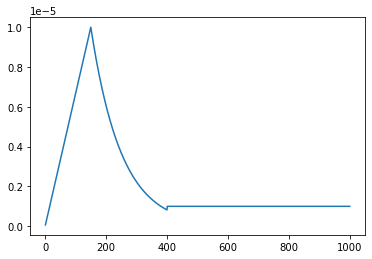

In [95]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [96]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Learning

In [97]:
# Compile model (Mehtab et al., 2021)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [98]:
# Fit model (Mehtab et al., 2021)
hist = model.fit(X_train, y_train, epochs = 200, validation_data = (X_val, y_val), callbacks=[callback])

Epoch 1/200
14/14 [==============================] - 4s 52ms/step - loss: 3922.6897 - root_mean_squared_error: 62.6314 - val_loss: 9016.0947 - val_root_mean_squared_error: 94.9531 - lr: 0.0000e+00
Epoch 2/200
14/14 [==============================] - 0s 22ms/step - loss: 3922.6536 - root_mean_squared_error: 62.6311 - val_loss: 9015.9307 - val_root_mean_squared_error: 94.9523 - lr: 6.6667e-08
Epoch 3/200
14/14 [==============================] - 0s 24ms/step - loss: 3922.5374 - root_mean_squared_error: 62.6302 - val_loss: 9015.5996 - val_root_mean_squared_error: 94.9505 - lr: 1.3333e-07
Epoch 4/200
14/14 [==============================] - 0s 26ms/step - loss: 3922.3391 - root_mean_squared_error: 62.6286 - val_loss: 9015.1035 - val_root_mean_squared_error: 94.9479 - lr: 2.0000e-07
Epoch 5/200
14/14 [==============================] - 0s 26ms/step - loss: 3922.0598 - root_mean_squared_error: 62.6264 - val_loss: 9014.4443 - val_root_mean_squared_error: 94.9444 - lr: 2.6667e-07
Epoch 6/200
14/

14/14 [==============================] - 0s 26ms/step - loss: 34.6623 - root_mean_squared_error: 5.8875 - val_loss: 168.9938 - val_root_mean_squared_error: 12.9998 - lr: 5.4667e-06
Epoch 84/200
14/14 [==============================] - 0s 24ms/step - loss: 28.0174 - root_mean_squared_error: 5.2931 - val_loss: 148.3767 - val_root_mean_squared_error: 12.1810 - lr: 5.5333e-06
Epoch 85/200
14/14 [==============================] - 0s 27ms/step - loss: 23.8673 - root_mean_squared_error: 4.8854 - val_loss: 131.6617 - val_root_mean_squared_error: 11.4744 - lr: 5.6000e-06
Epoch 86/200
14/14 [==============================] - 0s 26ms/step - loss: 21.1769 - root_mean_squared_error: 4.6018 - val_loss: 118.9048 - val_root_mean_squared_error: 10.9043 - lr: 5.6667e-06
Epoch 87/200
14/14 [==============================] - 0s 26ms/step - loss: 19.2561 - root_mean_squared_error: 4.3882 - val_loss: 110.7748 - val_root_mean_squared_error: 10.5250 - lr: 5.7333e-06
Epoch 88/200
14/14 [=======================

Epoch 126/200
14/14 [==============================] - 0s 26ms/step - loss: 4.9439 - root_mean_squared_error: 2.2235 - val_loss: 21.6563 - val_root_mean_squared_error: 4.6536 - lr: 8.3333e-06
Epoch 127/200
14/14 [==============================] - 0s 27ms/step - loss: 4.9089 - root_mean_squared_error: 2.2156 - val_loss: 21.2424 - val_root_mean_squared_error: 4.6089 - lr: 8.4000e-06
Epoch 128/200
14/14 [==============================] - 0s 26ms/step - loss: 4.8507 - root_mean_squared_error: 2.2024 - val_loss: 21.6338 - val_root_mean_squared_error: 4.6512 - lr: 8.4667e-06
Epoch 129/200
14/14 [==============================] - 0s 26ms/step - loss: 4.8127 - root_mean_squared_error: 2.1938 - val_loss: 21.1430 - val_root_mean_squared_error: 4.5981 - lr: 8.5333e-06
Epoch 130/200
14/14 [==============================] - 0s 25ms/step - loss: 4.7682 - root_mean_squared_error: 2.1836 - val_loss: 21.2117 - val_root_mean_squared_error: 4.6056 - lr: 8.6000e-06
Epoch 131/200
14/14 [===================

Epoch 169/200
14/14 [==============================] - 0s 25ms/step - loss: 4.1915 - root_mean_squared_error: 2.0473 - val_loss: 19.2731 - val_root_mean_squared_error: 4.3901 - lr: 8.3527e-06
Epoch 170/200
14/14 [==============================] - 0s 25ms/step - loss: 4.2004 - root_mean_squared_error: 2.0495 - val_loss: 19.8327 - val_root_mean_squared_error: 4.4534 - lr: 8.2696e-06
Epoch 171/200
14/14 [==============================] - 0s 25ms/step - loss: 4.1766 - root_mean_squared_error: 2.0437 - val_loss: 19.5243 - val_root_mean_squared_error: 4.4186 - lr: 8.1873e-06
Epoch 172/200
14/14 [==============================] - 0s 26ms/step - loss: 4.1973 - root_mean_squared_error: 2.0487 - val_loss: 20.0360 - val_root_mean_squared_error: 4.4762 - lr: 8.1058e-06
Epoch 173/200
14/14 [==============================] - 0s 26ms/step - loss: 4.2344 - root_mean_squared_error: 2.0578 - val_loss: 19.1975 - val_root_mean_squared_error: 4.3815 - lr: 8.0252e-06
Epoch 174/200
14/14 [===================

In [99]:
history_dict = hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

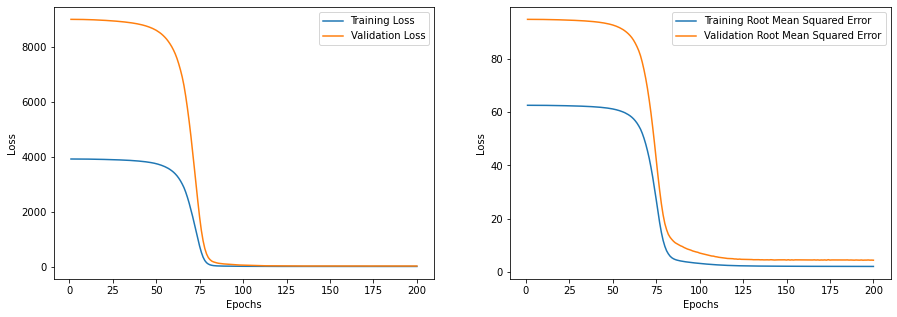

In [100]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Prediction

In [101]:
prediction = model.predict(X_test)

5/5 [==============================] - 0s 7ms/step


In [102]:
len(prediction.reshape(-1))

695

In [103]:
temp1 = test.tail(695)

In [104]:
temp1['Forecast'] = prediction.reshape(-1)

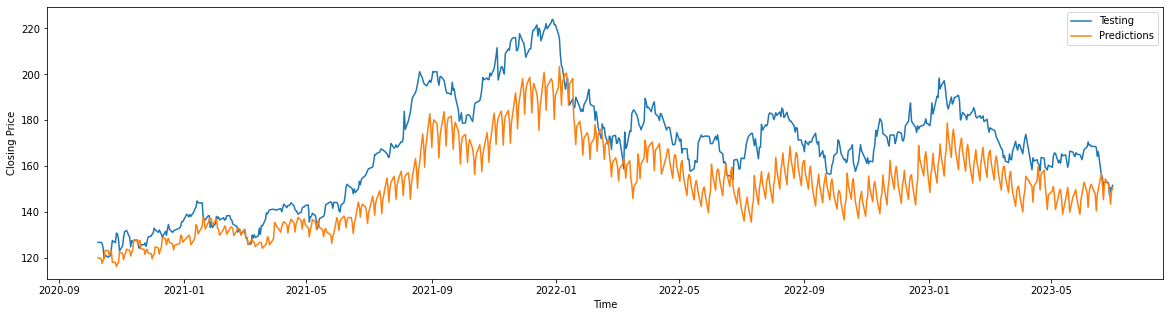

In [105]:
plt.figure(figsize=(20, 5))
plt.plot(temp1['Close'], label = 'Testing')
plt.plot(temp1['Forecast'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [106]:
rmse = math.sqrt(mean_squared_error(y_test.reshape(-1, 5), prediction))
mape = np.mean(np.abs(prediction - y_test.reshape(-1, 5))/np.abs(y_test.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 17.91665846313499
MAPE: 0.08741079048437776


In [107]:
temp1

,Close,pe-ratio,pb-ratio,Forecast
Date,,,,
2020-10-09,126.661209,28.965117,3.009257,119.911774
2020-10-12,126.661209,28.965117,3.009257,119.614937
2020-10-13,126.226120,28.965117,3.009257,117.441101
2020-10-14,124.098984,28.965117,3.009257,118.841522
2020-10-15,119.699684,28.965117,3.009257,119.607071
...,...,...,...,...
2023-06-26,152.600006,23.026846,3.013593,151.868591
2023-06-27,147.199997,23.026846,3.013593,148.313141
2023-06-28,150.500000,23.026846,3.013593,143.323944


In [108]:
# Extract actual data from SIE
tem1 = MRK['Close'].tolist()[:len(MRK)-695]
# Extract forecasted date from above result
tem2 = temp1['Forecast'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['MRK'] = tem3

In [109]:
result1

,SIE,Forecasted,DTE,ALV,MRK
Date,,,,,
2010-01-04,39.892437,N,4.953136,45.519119,26.576839
2010-01-05,39.916805,N,4.911083,45.657921,26.381214
2010-01-06,40.063042,N,4.789590,46.012665,26.364910
2010-01-07,40.538315,N,4.698472,45.483131,26.919188
2010-01-08,40.794235,N,4.724171,45.236355,26.646120
...,...,...,...,...,...
2023-06-26,162.862976,Y,36.315617,204.726959,151.868591
2023-06-27,160.656967,Y,37.594303,207.693985,148.313141
2023-06-28,162.757492,Y,37.063148,206.646469,143.323944


## 1.5. DHL

In [110]:
DHL

,Open,High,Low,Close,Volume,Dividends,Stock Splits,pe-ratio,ps-ratio,pb-ratio,Ticker
Date,,,,,,,,,,,
2010-01-04,13.550000,13.980000,13.550000,13.980,3020790.0,0.0,0.0,25.443396,NaN,1.970697,deutsche-post
2010-01-05,13.935000,14.135000,13.830000,14.000,2735783.0,0.0,0.0,25.443396,NaN,1.970697,deutsche-post
2010-01-06,13.980000,14.230000,13.925000,14.155,2595800.0,0.0,0.0,25.443396,NaN,1.970697,deutsche-post
2010-01-07,14.110000,14.195000,14.020000,14.125,2907679.0,0.0,0.0,25.443396,NaN,1.970697,deutsche-post
2010-01-08,14.140000,14.525000,14.060000,14.460,5462896.0,0.0,0.0,25.443396,NaN,1.970697,deutsche-post
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,43.435001,43.514999,42.619999,43.000,1812008.0,0.0,0.0,10.613300,0.578296,1.588590,deutsche-post
2023-06-27,43.314999,43.590000,43.174999,43.500,2197942.0,0.0,0.0,10.613300,0.578296,1.588590,deutsche-post
2023-06-28,43.709999,44.415001,43.645000,44.305,1739606.0,0.0,0.0,10.613300,0.578296,1.588590,deutsche-post


In [111]:
DHL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3441 entries, 2010-01-04 to 2023-06-30
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3441 non-null   float64
 1   High          3441 non-null   float64
 2   Low           3441 non-null   float64
 3   Close         3441 non-null   float64
 4   Volume        3441 non-null   float64
 5   Dividends     3441 non-null   float64
 6   Stock Splits  3441 non-null   float64
 7   pe-ratio      3441 non-null   float64
 8   ps-ratio      3379 non-null   float64
 9   pb-ratio      3441 non-null   float64
 10  Ticker        3441 non-null   object 
dtypes: float64(10), object(1)
memory usage: 322.6+ KB


In [112]:
DHL_df1 = DHL[["Close", "pe-ratio", "pb-ratio"]]
DHL_df1

,Close,pe-ratio,pb-ratio
Date,,,
2010-01-04,13.980,25.443396,1.970697
2010-01-05,14.000,25.443396,1.970697
2010-01-06,14.155,25.443396,1.970697
2010-01-07,14.125,25.443396,1.970697
2010-01-08,14.460,25.443396,1.970697
...,...,...,...
2023-06-26,43.000,10.613300,1.588590
2023-06-27,43.500,10.613300,1.588590
2023-06-28,44.305,10.613300,1.588590


### Data Proprocessing

In [113]:
# Split data to train set and test set
train, test = split(DHL_df1, end_date, test_start_date)

In [114]:
# Reconcile length of data set and subsets
DHL_df1.shape[0] == train.shape[0] + test.shape[0]

True

In [115]:
# Process data
X_train, y_train = Dataset(train, 3)
X_test, y_test = Dataset(test, 3)

In [116]:
# Split train set to train set and validation set
X_train, X_val = split_val(X_train, 0.8)
y_train, y_val = split_val(y_train, 0.8)

### Model

In [117]:
# Define model (Mehtab et al., 2021)
def Model():
    model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 3), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(300, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
    return model

In [118]:
model = Model()

In [119]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 5, 200)            163200    
                                                                 
 lstm_9 (LSTM)               (None, 5, 200)            320800    
                                                                 
 lstm_10 (LSTM)              (None, 200)               320800    
                                                                 
 dense_17 (Dense)            (None, 300)               60300     
                                                                 
 dense_18 (Dense)            (None, 200)               60200     
                                                                 
 dense_19 (Dense)            (None, 100)               20100     
                                                                 
 dense_20 (Dense)            (None, 50)               

### Custom Learning Rate

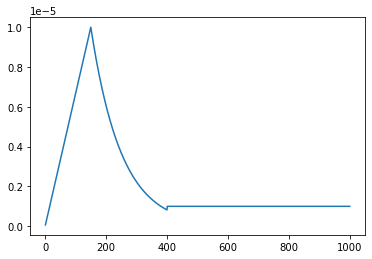

In [120]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [121]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

### Learning

In [122]:
# Compile model (Mehtab et al., 2021)
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [123]:
# Fit model (Mehtab et al., 2021)
hist = model.fit(X_train, y_train, epochs = 200, validation_data = (X_val, y_val), callbacks=[callback])

Epoch 1/200
14/14 [==============================] - 6s 98ms/step - loss: 576.9732 - root_mean_squared_error: 24.0203 - val_loss: 915.9027 - val_root_mean_squared_error: 30.2639 - lr: 0.0000e+00
Epoch 2/200
14/14 [==============================] - 1s 36ms/step - loss: 576.9714 - root_mean_squared_error: 24.0202 - val_loss: 915.8959 - val_root_mean_squared_error: 30.2638 - lr: 6.6667e-08
Epoch 3/200
14/14 [==============================] - 1s 35ms/step - loss: 576.9651 - root_mean_squared_error: 24.0201 - val_loss: 915.8825 - val_root_mean_squared_error: 30.2635 - lr: 1.3333e-07
Epoch 4/200
14/14 [==============================] - 1s 54ms/step - loss: 576.9544 - root_mean_squared_error: 24.0199 - val_loss: 915.8617 - val_root_mean_squared_error: 30.2632 - lr: 2.0000e-07
Epoch 5/200
14/14 [==============================] - 1s 46ms/step - loss: 576.9395 - root_mean_squared_error: 24.0196 - val_loss: 915.8333 - val_root_mean_squared_error: 30.2627 - lr: 2.6667e-07
Epoch 6/200
14/14 [======

Epoch 43/200
14/14 [==============================] - 1s 53ms/step - loss: 567.0684 - root_mean_squared_error: 23.8132 - val_loss: 898.8030 - val_root_mean_squared_error: 29.9800 - lr: 2.8000e-06
Epoch 44/200
14/14 [==============================] - 1s 56ms/step - loss: 565.7713 - root_mean_squared_error: 23.7859 - val_loss: 896.5389 - val_root_mean_squared_error: 29.9423 - lr: 2.8667e-06
Epoch 45/200
14/14 [==============================] - 1s 51ms/step - loss: 564.2734 - root_mean_squared_error: 23.7544 - val_loss: 893.8209 - val_root_mean_squared_error: 29.8968 - lr: 2.9333e-06
Epoch 46/200
14/14 [==============================] - 1s 56ms/step - loss: 562.4943 - root_mean_squared_error: 23.7170 - val_loss: 890.5347 - val_root_mean_squared_error: 29.8418 - lr: 3.0000e-06
Epoch 47/200
14/14 [==============================] - 1s 55ms/step - loss: 560.3500 - root_mean_squared_error: 23.6717 - val_loss: 886.5750 - val_root_mean_squared_error: 29.7754 - lr: 3.0667e-06
Epoch 48/200
14/14 [

Epoch 85/200
14/14 [==============================] - 1s 42ms/step - loss: 106.1899 - root_mean_squared_error: 10.3048 - val_loss: 112.2372 - val_root_mean_squared_error: 10.5942 - lr: 5.6000e-06
Epoch 86/200
14/14 [==============================] - 1s 45ms/step - loss: 70.8130 - root_mean_squared_error: 8.4150 - val_loss: 62.5459 - val_root_mean_squared_error: 7.9086 - lr: 5.6667e-06
Epoch 87/200
14/14 [==============================] - 1s 58ms/step - loss: 46.0262 - root_mean_squared_error: 6.7843 - val_loss: 35.9153 - val_root_mean_squared_error: 5.9929 - lr: 5.7333e-06
Epoch 88/200
14/14 [==============================] - 1s 56ms/step - loss: 32.7124 - root_mean_squared_error: 5.7195 - val_loss: 21.8252 - val_root_mean_squared_error: 4.6717 - lr: 5.8000e-06
Epoch 89/200
14/14 [==============================] - 1s 54ms/step - loss: 24.9286 - root_mean_squared_error: 4.9929 - val_loss: 13.0336 - val_root_mean_squared_error: 3.6102 - lr: 5.8667e-06
Epoch 90/200
14/14 [================

Epoch 128/200
14/14 [==============================] - 1s 45ms/step - loss: 1.7224 - root_mean_squared_error: 1.3124 - val_loss: 2.0363 - val_root_mean_squared_error: 1.4270 - lr: 8.4667e-06
Epoch 129/200
14/14 [==============================] - 1s 50ms/step - loss: 1.6464 - root_mean_squared_error: 1.2831 - val_loss: 1.9966 - val_root_mean_squared_error: 1.4130 - lr: 8.5333e-06
Epoch 130/200
14/14 [==============================] - 1s 40ms/step - loss: 1.5757 - root_mean_squared_error: 1.2553 - val_loss: 1.9290 - val_root_mean_squared_error: 1.3889 - lr: 8.6000e-06
Epoch 131/200
14/14 [==============================] - 1s 40ms/step - loss: 1.5311 - root_mean_squared_error: 1.2374 - val_loss: 2.1148 - val_root_mean_squared_error: 1.4542 - lr: 8.6667e-06
Epoch 132/200
14/14 [==============================] - 1s 43ms/step - loss: 1.4594 - root_mean_squared_error: 1.2080 - val_loss: 1.9497 - val_root_mean_squared_error: 1.3963 - lr: 8.7333e-06
Epoch 133/200
14/14 [========================

Epoch 171/200
14/14 [==============================] - 1s 53ms/step - loss: 0.6990 - root_mean_squared_error: 0.8361 - val_loss: 1.7979 - val_root_mean_squared_error: 1.3408 - lr: 8.1873e-06
Epoch 172/200
14/14 [==============================] - 1s 40ms/step - loss: 0.6868 - root_mean_squared_error: 0.8287 - val_loss: 2.0385 - val_root_mean_squared_error: 1.4278 - lr: 8.1058e-06
Epoch 173/200
14/14 [==============================] - 1s 53ms/step - loss: 0.6897 - root_mean_squared_error: 0.8305 - val_loss: 1.8138 - val_root_mean_squared_error: 1.3468 - lr: 8.0252e-06
Epoch 174/200
14/14 [==============================] - 1s 37ms/step - loss: 0.6831 - root_mean_squared_error: 0.8265 - val_loss: 1.9317 - val_root_mean_squared_error: 1.3899 - lr: 7.9453e-06
Epoch 175/200
14/14 [==============================] - 1s 43ms/step - loss: 0.6737 - root_mean_squared_error: 0.8208 - val_loss: 1.9341 - val_root_mean_squared_error: 1.3907 - lr: 7.8663e-06
Epoch 176/200
14/14 [========================

In [124]:
history_dict = hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

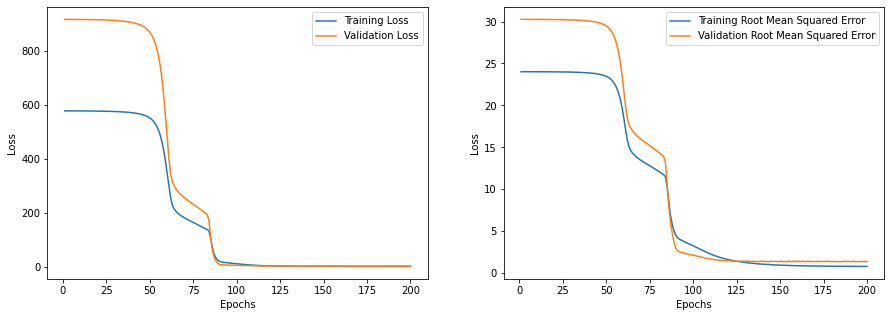

In [125]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Prediction

In [126]:
prediction = model.predict(X_test)

5/5 [==============================] - 1s 15ms/step


In [127]:
len(prediction.reshape(-1))

695

In [128]:
temp1 = test.tail(695)

In [129]:
temp1['Forecast'] = prediction.reshape(-1)

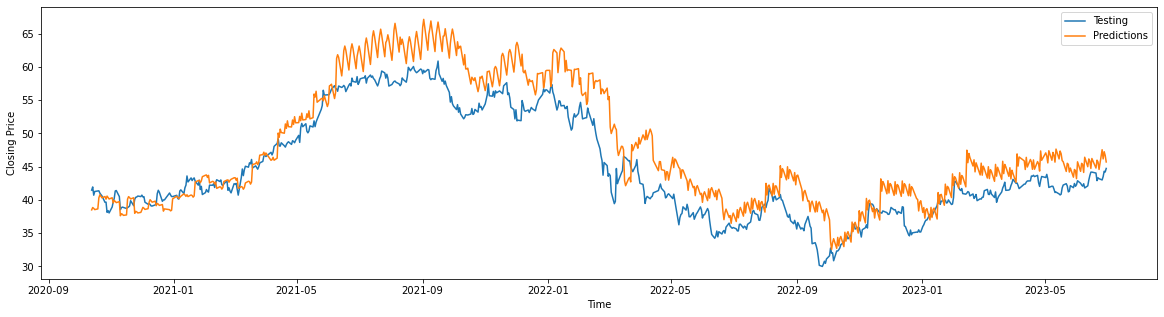

In [130]:
plt.figure(figsize=(20, 5))
plt.plot(temp1['Close'], label = 'Testing')
plt.plot(temp1['Forecast'], label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [131]:
rmse = math.sqrt(mean_squared_error(y_test.reshape(-1, 5), prediction))
mape = np.mean(np.abs(prediction - y_test.reshape(-1, 5))/np.abs(y_test.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 4.2142220744091
MAPE: 0.07858213672177704


In [132]:
temp1

,Close,pe-ratio,pb-ratio,Forecast
Date,,,,
2020-10-13,41.470001,18.933283,3.600308,38.500057
2020-10-14,41.950001,18.933283,3.600308,38.855515
2020-10-15,40.709999,18.933283,3.600308,38.726570
2020-10-16,41.270000,18.933283,3.600308,38.541954
2020-10-19,41.340000,18.933283,3.600308,38.650379
...,...,...,...,...
2023-06-26,43.000000,10.613300,1.588590,47.543961
2023-06-27,43.500000,10.613300,1.588590,46.161736
2023-06-28,44.305000,10.613300,1.588590,47.245037


In [133]:
# Extract actual data from SIE
tem1 = DHL['Close'].tolist()[:len(DHL)+8-695]
# Extract forecasted date from above result
tem2 = temp1['Forecast'].tolist()
# Combine them to a list
tem3 = tem1 + tem2
# Create a column from the resulted list
result1['DHL'] = tem3

In [134]:
result1

,SIE,Forecasted,DTE,ALV,MRK,DHL
Date,,,,,,
2010-01-04,39.892437,N,4.953136,45.519119,26.576839,13.980000
2010-01-05,39.916805,N,4.911083,45.657921,26.381214,14.000000
2010-01-06,40.063042,N,4.789590,46.012665,26.364910,14.155000
2010-01-07,40.538315,N,4.698472,45.483131,26.919188,14.125000
2010-01-08,40.794235,N,4.724171,45.236355,26.646120,14.460000
...,...,...,...,...,...,...
2023-06-26,162.862976,Y,36.315617,204.726959,151.868591,47.543961
2023-06-27,160.656967,Y,37.594303,207.693985,148.313141,46.161736
2023-06-28,162.757492,Y,37.063148,206.646469,143.323944,47.245037


In [135]:
# Define the desired column order
desired_order = ['SIE', 'DTE', 'ALV', 'MRK', 'DHL', 'Forecasted']

# Rearrange columns
result = result1[desired_order]
result

,SIE,DTE,ALV,MRK,DHL,Forecasted
Date,,,,,,
2010-01-04,39.892437,4.953136,45.519119,26.576839,13.980000,N
2010-01-05,39.916805,4.911083,45.657921,26.381214,14.000000,N
2010-01-06,40.063042,4.789590,46.012665,26.364910,14.155000,N
2010-01-07,40.538315,4.698472,45.483131,26.919188,14.125000,N
2010-01-08,40.794235,4.724171,45.236355,26.646120,14.460000,N
...,...,...,...,...,...,...
2023-06-26,162.862976,36.315617,204.726959,151.868591,47.543961,Y
2023-06-27,160.656967,37.594303,207.693985,148.313141,46.161736,Y
2023-06-28,162.757492,37.063148,206.646469,143.323944,47.245037,Y


In [136]:
result.to_csv('LSTM_3 feature.csv', index=True)

# Bibliography

- Mehtab, S., Sen, J., & Dutta, A. (2021). Stock price prediction using machine learning and LSTM-based deep learning models. In _Machine Learning and Metaheuristics Algorithms, and Applications: Second Symposium, SoMMA 2020, Chennai, India, October 14–17, 2020, Revised Selected Papers 2_ (pp. 88-106). Springer Singapore